In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import random
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import os
from PIL import Image 
import tensorflow as tf
import keras.backend as K
from keras.applications import Xception
from keras.layers import UpSampling2D, Conv2D, Activation, LeakyReLU, BatchNormalization
from keras import Model
from keras.losses import binary_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler
from tqdm import tqdm_notebook

Using TensorFlow backend.


### The Data

In [2]:
df_train = pd.read_csv('./input/severstal-steel-defect-detection/train.csv')

In [3]:
df_train.shape

(50272, 2)

In [4]:
df_train.head()

,ImageId_ClassId,EncodedPixels
0,0002cc93b.jpg_1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0002cc93b.jpg_2,NaN
2,0002cc93b.jpg_3,NaN
3,0002cc93b.jpg_4,NaN
4,00031f466.jpg_1,NaN


In [5]:
df_train['Defect'] = df_train['EncodedPixels'].notnull()
df_train['ClassId'] = df_train['ImageId_ClassId'].str[-1:]
df_train['ImageId'] = df_train['ImageId_ClassId'].str[:-2]

In [6]:
df_train.shape

(50272, 5)

In [7]:
df_train.head()

,ImageId_ClassId,EncodedPixels,Defect,ClassId,ImageId
0,0002cc93b.jpg_1,29102 12 29346 24 29602 24 29858 24 30114 24 3...,True,1,0002cc93b.jpg
1,0002cc93b.jpg_2,NaN,False,2,0002cc93b.jpg
2,0002cc93b.jpg_3,NaN,False,3,0002cc93b.jpg
3,0002cc93b.jpg_4,NaN,False,4,0002cc93b.jpg
4,00031f466.jpg_1,NaN,False,1,00031f466.jpg


In [8]:
df_train = df_train[['ImageId','ClassId','Defect','EncodedPixels']]

In [9]:
df_train.shape

(50272, 4)

In [10]:
df_train.head()

,ImageId,ClassId,Defect,EncodedPixels
0,0002cc93b.jpg,1,True,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0002cc93b.jpg,2,False,NaN
2,0002cc93b.jpg,3,False,NaN
3,0002cc93b.jpg,4,False,NaN
4,00031f466.jpg,1,False,NaN


In [11]:
df_train = df_train[df_train.Defect]

In [12]:
df_train.shape

(7095, 4)

In [13]:
df_train.head()

,ImageId,ClassId,Defect,EncodedPixels
0,0002cc93b.jpg,1,True,29102 12 29346 24 29602 24 29858 24 30114 24 3...
18,0007a71bf.jpg,3,True,18661 28 18863 82 19091 110 19347 110 19603 11...
20,000a4bcdd.jpg,1,True,37607 3 37858 8 38108 14 38359 20 38610 25 388...
27,000f6bf48.jpg,4,True,131973 1 132228 4 132483 6 132738 8 132993 11 ...
30,0014fce06.jpg,3,True,229501 11 229741 33 229981 55 230221 77 230468...


In [14]:
df_train = df_train.drop(['Defect'], axis=1)

In [15]:
df_train.head()

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
18,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
20,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
27,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
30,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...


### Utility functions

In [16]:
# This function uses a 0 based start index (arrays, matrixes and imgs start a index 0)
def mask2rle(img):
    tmp = np.rot90( np.flipud( img ), k=3 )
    rle = []
    lastColor = 0;
    startpos = 0
    endpos = 0

    tmp = tmp.reshape(-1,1)   
    for i in range( len(tmp) ):
        if (lastColor==0) and tmp[i]>0:
            startpos = i
            lastColor = 1
        elif (lastColor==1)and(tmp[i]==0):
            endpos = i-1
            lastColor = 0
            rle.append( str(startpos)+' '+str(endpos-startpos+1) )
    return " ".join(rle)

In [17]:
img = [
    [0, 1, 0, 0, 0],
    [0, 1, 1, 1, 0], 
    [0, 1, 0, 1, 0],
    [0, 1, 1, 1, 0], 
    [0, 0, 0, 1, 0],
]

res = mask2rle(img)
print(res)

5 4 11 1 13 1 16 4


In [18]:
# This function uses a 0 based start index (arrays, matrixes and imgs start a index 0)
def rle2mask(rle, imgshape):
    width = imgshape[0]
    height= imgshape[1]
    
    mask= np.zeros( width*height ).astype(np.uint8)
    
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
        current_position += lengths[index]
        
    return np.flipud( np.rot90( mask.reshape(height, width), k=1 ) )

In [19]:
res = rle2mask("5 4 11 1 13 1 16 4", (5, 5))
print(res)

[[0 1 0 0 0]
 [0 1 1 1 0]
 [0 1 0 1 0]
 [0 1 1 1 0]
 [0 0 0 1 0]]


### Xception Model in Keras

In [20]:
ORIG_IMG_SIZE_HEIGHT = 256
ORIG_IMG_SIZE_WIDTH = 1600
TRAIN_IMG_SIZE_HEIGHT =128
TRAIN_IMG_SIZE_WIDTH = 800

BATCH_SIZE = 2
EPOCHS = 1
PATIENCE = 2

In [21]:
import keras

class DataGenerator(keras.utils.Sequence):
    def __init__(self, df, batch_size = BATCH_SIZE, subset="train", shuffle=False, 
                 preprocess=None, info={}):
        super().__init__()
        self.df = df
        self.shuffle = shuffle
        self.subset = subset
        self.batch_size = batch_size
        self.preprocess = preprocess
        self.info = info
        
        if self.subset == "train":
            self.data_path = './input/severstal-steel-defect-detection/train_images/'
        elif self.subset == "test":
            self.data_path = './input/severstal-steel-defect-detection/test_images/'
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.df))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def __getitem__(self, index): 
        X = np.empty((self.batch_size,128,800,3),dtype=np.float32)
        y = np.empty((self.batch_size,128,800,1),dtype=np.int8)
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        for i,f in enumerate(self.df['ImageId'].iloc[indexes]):
            #print(f)
            self.info[index*self.batch_size+i]=f
            X[i,] = Image.open(self.data_path + f).resize((800,128))
            if self.subset == 'train': 
                mask_i = rle2mask(self.df['EncodedPixels'].iloc[indexes[i]], (256, 1600))
                y[i,:,:,0] = mask_i[::2,::2]
                #y = np.expand_dims(y, axis=2)
                
        if self.preprocess!=None: X = self.preprocess(X)
        if self.subset == 'train': return X, y
        else: return X

In [22]:
idx = int(0.8*len(df_train))
train_batches = DataGenerator(df_train.iloc[:idx],shuffle=True,preprocess=None)
valid_batches = DataGenerator(df_train.iloc[idx:],preprocess=None)

X, y = train_batches.__getitem__(17) 
print(X.shape)
print(y.shape)
print(X[0].shape)
print(y[0].shape)
#print(train_batches.__getitem__(0)[1][0].shape)


(2, 128, 800, 3)
(2, 128, 800, 1)
(128, 800, 3)
(128, 800, 1)


In [23]:
encoding = df_train[df_train['ImageId']=='2e35ebe13.jpg']['EncodedPixels']
print(encoding)

9130    91379 6 91635 12 91890 13 92146 13 92401 14 92...
Name: EncodedPixels, dtype: object


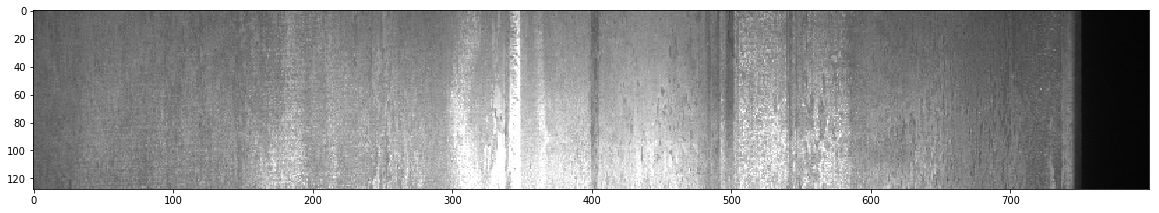

In [24]:
#img = Image.fromarray(data)
#img.save('my.png')
#img.show()
plt.figure(figsize=(20,4))

data = X[0]
if (data.shape[2] == 1):
    plt.imshow(np.squeeze(data, axis=2), cmap="gray")
else:
    plt.imshow(data.astype(int))

#plt.figure(figsize=(10,20))
plt.show()

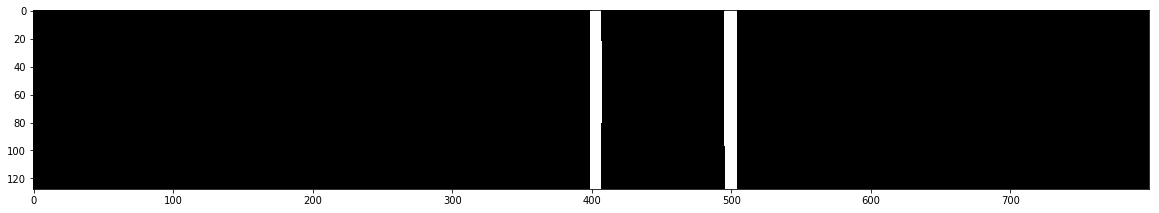

In [25]:
plt.figure(figsize=(20,4))

data = y[0]
if (data.shape[2] == 1):
    plt.imshow(np.squeeze(data, axis=2), cmap="gray")
else:
    plt.imshow(data.astype(int))

#plt.figure(figsize=(10,20))
plt.show()

In [26]:
def dice_coeff(y_true, y_pred):
    smooth = 1
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def bce_dice_loss(y_true, y_pred):
    loss = 0.5 * binary_crossentropy(y_true, y_pred) - 2*dice_coeff(y_true, y_pred)
    return loss


In [27]:
base_model = Xception(weights='imagenet', input_shape=(TRAIN_IMG_SIZE_HEIGHT, TRAIN_IMG_SIZE_WIDTH, 3), include_top=False) #include_top=False excludes final FC layer
base_model.summary()


Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 800, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 63, 399, 32)  864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 63, 399, 32)  128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 63, 399, 32)  0           block1_conv1_bn[0][0]            
_____________________________________

__________________________________________________________________________________________________
block5_sepconv1 (SeparableConv2 (None, 8, 50, 728)   536536      block5_sepconv1_act[0][0]        
__________________________________________________________________________________________________
block5_sepconv1_bn (BatchNormal (None, 8, 50, 728)   2912        block5_sepconv1[0][0]            
__________________________________________________________________________________________________
block5_sepconv2_act (Activation (None, 8, 50, 728)   0           block5_sepconv1_bn[0][0]         
__________________________________________________________________________________________________
block5_sepconv2 (SeparableConv2 (None, 8, 50, 728)   536536      block5_sepconv2_act[0][0]        
__________________________________________________________________________________________________
block5_sepconv2_bn (BatchNormal (None, 8, 50, 728)   2912        block5_sepconv2[0][0]            
__________

__________________________________________________________________________________________________
block9_sepconv1_act (Activation (None, 8, 50, 728)   0           add_7[0][0]                      
__________________________________________________________________________________________________
block9_sepconv1 (SeparableConv2 (None, 8, 50, 728)   536536      block9_sepconv1_act[0][0]        
__________________________________________________________________________________________________
block9_sepconv1_bn (BatchNormal (None, 8, 50, 728)   2912        block9_sepconv1[0][0]            
__________________________________________________________________________________________________
block9_sepconv2_act (Activation (None, 8, 50, 728)   0           block9_sepconv1_bn[0][0]         
__________________________________________________________________________________________________
block9_sepconv2 (SeparableConv2 (None, 8, 50, 728)   536536      block9_sepconv2_act[0][0]        
__________

add_11 (Add)                    (None, 8, 50, 728)   0           block12_sepconv3_bn[0][0]        
                                                                 add_10[0][0]                     
__________________________________________________________________________________________________
block13_sepconv1_act (Activatio (None, 8, 50, 728)   0           add_11[0][0]                     
__________________________________________________________________________________________________
block13_sepconv1 (SeparableConv (None, 8, 50, 728)   536536      block13_sepconv1_act[0][0]       
__________________________________________________________________________________________________
block13_sepconv1_bn (BatchNorma (None, 8, 50, 728)   2912        block13_sepconv1[0][0]           
__________________________________________________________________________________________________
block13_sepconv2_act (Activatio (None, 8, 50, 728)   0           block13_sepconv1_bn[0][0]        
__________

In [28]:
base_out = base_model.output
up1 = UpSampling2D(32, interpolation='bilinear')(base_out)
conv1 = Conv2D(1, (1, 1))(up1)
conv1 = Activation('sigmoid')(conv1)

model = Model(base_model.input, conv1)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 800, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 63, 399, 32)  864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 63, 399, 32)  128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 63, 399, 32)  0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

block5_sepconv1_bn (BatchNormal (None, 8, 50, 728)   2912        block5_sepconv1[0][0]            
__________________________________________________________________________________________________
block5_sepconv2_act (Activation (None, 8, 50, 728)   0           block5_sepconv1_bn[0][0]         
__________________________________________________________________________________________________
block5_sepconv2 (SeparableConv2 (None, 8, 50, 728)   536536      block5_sepconv2_act[0][0]        
__________________________________________________________________________________________________
block5_sepconv2_bn (BatchNormal (None, 8, 50, 728)   2912        block5_sepconv2[0][0]            
__________________________________________________________________________________________________
block5_sepconv3_act (Activation (None, 8, 50, 728)   0           block5_sepconv2_bn[0][0]         
__________________________________________________________________________________________________
block5_sep

block9_sepconv1 (SeparableConv2 (None, 8, 50, 728)   536536      block9_sepconv1_act[0][0]        
__________________________________________________________________________________________________
block9_sepconv1_bn (BatchNormal (None, 8, 50, 728)   2912        block9_sepconv1[0][0]            
__________________________________________________________________________________________________
block9_sepconv2_act (Activation (None, 8, 50, 728)   0           block9_sepconv1_bn[0][0]         
__________________________________________________________________________________________________
block9_sepconv2 (SeparableConv2 (None, 8, 50, 728)   536536      block9_sepconv2_act[0][0]        
__________________________________________________________________________________________________
block9_sepconv2_bn (BatchNormal (None, 8, 50, 728)   2912        block9_sepconv2[0][0]            
__________________________________________________________________________________________________
block9_sep

block13_sepconv1_act (Activatio (None, 8, 50, 728)   0           add_11[0][0]                     
__________________________________________________________________________________________________
block13_sepconv1 (SeparableConv (None, 8, 50, 728)   536536      block13_sepconv1_act[0][0]       
__________________________________________________________________________________________________
block13_sepconv1_bn (BatchNorma (None, 8, 50, 728)   2912        block13_sepconv1[0][0]           
__________________________________________________________________________________________________
block13_sepconv2_act (Activatio (None, 8, 50, 728)   0           block13_sepconv1_bn[0][0]        
__________________________________________________________________________________________________
block13_sepconv2 (SeparableConv (None, 8, 50, 1024)  752024      block13_sepconv2_act[0][0]       
__________________________________________________________________________________________________
block13_se

In [29]:
from keras.optimizers import RMSprop

#model.compile(loss=bce_dice_loss, optimizer='adam', metrics=[iou_metric])
model.compile(optimizer=RMSprop(lr=0.00075), loss=bce_dice_loss, metrics=['accuracy', dice_coeff])

In [30]:
# A decreasing learning rate schedule (continuous decrease)
def continuous_decay(epoch):
    initial_lrate = 0.01
    lr = initial_lrate * (0.1 ** int(epoch / 10))
    return lr

# Another decreasing learning rate schedule (stepped decrease)
def step_decay(epoch):
    initial_lrate = 0.01
    drop = 0.5
    epochs_drop = 5.0
    lr = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lr

def get_callback(patient):
    ES = EarlyStopping(
        monitor='loss', 
        patience=patient, 
        mode='max', 
        verbose=1)
    RR = ReduceLROnPlateau(
        monitor = 'loss', 
        factor = 0.5, 
        patience = patient / 2, 
        min_lr=0.000001, 
        verbose=1, 
        mode='max')
    LR = LearningRateScheduler(
        continuous_decay,
        verbose=1)
    MC = ModelCheckpoint(
        filepath='./Xcep_model_CD_LR0_01.h5', 
        save_best_only=True,
        verbose=1)
#    return [ES, RR, LR, MC]
#    return [ES, MC, RR]
    return [ES, MC, LR]


In [31]:
idx = int(0.8*len(df_train))
train_batches = DataGenerator(df_train.iloc[:idx],shuffle=True,preprocess=None)
valid_batches = DataGenerator(df_train.iloc[idx:],preprocess=None)

history = model.fit_generator(train_batches,
                              epochs=EPOCHS,    
                              validation_data=valid_batches,
                              verbose=1,
                              shuffle=True,
                              callbacks = get_callback(PATIENCE)
                             )

Instructions for updating:
Use tf.cast instead.
Epoch 1/1

Epoch 00001: LearningRateScheduler setting learning rate to 0.01.


 132/2838 [>.............................] - ETA: 9:45:10 - loss: -0.2140 - acc: 0.4985 - dice_coeff: 0.28 - ETA: 5:00:26 - loss: 0.6866 - acc: 0.4449 - dice_coeff: 0.2643 - ETA: 3:25:26 - loss: 0.4883 - acc: 0.6051 - dice_coeff: 0.201 - ETA: 2:37:59 - loss: 0.4392 - acc: 0.7019 - dice_coeff: 0.152 - ETA: 2:09:28 - loss: 0.3922 - acc: 0.7575 - dice_coeff: 0.130 - ETA: 1:50:28 - loss: 0.3441 - acc: 0.7919 - dice_coeff: 0.121 - ETA: 1:36:53 - loss: 0.2994 - acc: 0.8124 - dice_coeff: 0.122 - ETA: 1:26:42 - loss: 0.2854 - acc: 0.8326 - dice_coeff: 0.110 - ETA: 1:18:48 - loss: 0.2086 - acc: 0.8107 - dice_coeff: 0.144 - ETA: 1:12:28 - loss: 0.2582 - acc: 0.8013 - dice_coeff: 0.131 - ETA: 1:07:17 - loss: 0.2515 - acc: 0.8177 - dice_coeff: 0.123 - ETA: 1:02:57 - loss: 0.2267 - acc: 0.8264 - dice_coeff: 0.125 - ETA: 59:18 - loss: 0.1752 - acc: 0.8214 - dice_coeff: 0.1434  - ETA: 56:09 - loss: 0.1696 - acc: 0.8317 - dice_coeff: 0.138 - ETA: 53:26 - loss: 0.1523 - acc: 0.8376 - dice_coeff: 0.140 

 264/2838 [=>............................] - ETA: 19:07 - loss: 0.0445 - acc: 0.9108 - dice_coeff: 0.098 - ETA: 19:05 - loss: 0.0451 - acc: 0.9107 - dice_coeff: 0.097 - ETA: 19:03 - loss: 0.0468 - acc: 0.9089 - dice_coeff: 0.098 - ETA: 19:00 - loss: 0.0465 - acc: 0.9090 - dice_coeff: 0.098 - ETA: 18:58 - loss: 0.0454 - acc: 0.9089 - dice_coeff: 0.098 - ETA: 18:56 - loss: 0.0436 - acc: 0.9077 - dice_coeff: 0.100 - ETA: 18:54 - loss: 0.0463 - acc: 0.9063 - dice_coeff: 0.099 - ETA: 18:52 - loss: 0.0459 - acc: 0.9059 - dice_coeff: 0.099 - ETA: 18:50 - loss: 0.0450 - acc: 0.9054 - dice_coeff: 0.099 - ETA: 18:48 - loss: 0.0454 - acc: 0.9054 - dice_coeff: 0.099 - ETA: 18:46 - loss: 0.0461 - acc: 0.9052 - dice_coeff: 0.098 - ETA: 18:44 - loss: 0.0461 - acc: 0.9052 - dice_coeff: 0.098 - ETA: 18:42 - loss: 0.0434 - acc: 0.9048 - dice_coeff: 0.099 - ETA: 18:40 - loss: 0.0437 - acc: 0.9045 - dice_coeff: 0.099 - ETA: 18:38 - loss: 0.0396 - acc: 0.9044 - dice_coeff: 0.101 - ETA: 18:36 - loss: 0.0354

 396/2838 [===>..........................] - ETA: 16:17 - loss: -0.1178 - acc: 0.9022 - dice_coeff: 0.16 - ETA: 16:17 - loss: -0.1170 - acc: 0.9022 - dice_coeff: 0.16 - ETA: 16:16 - loss: -0.1160 - acc: 0.9020 - dice_coeff: 0.16 - ETA: 16:15 - loss: -0.1160 - acc: 0.9020 - dice_coeff: 0.16 - ETA: 16:14 - loss: -0.1162 - acc: 0.9022 - dice_coeff: 0.16 - ETA: 16:13 - loss: -0.1184 - acc: 0.9023 - dice_coeff: 0.16 - ETA: 16:13 - loss: -0.1192 - acc: 0.9025 - dice_coeff: 0.16 - ETA: 16:12 - loss: -0.1214 - acc: 0.9026 - dice_coeff: 0.16 - ETA: 16:11 - loss: -0.1235 - acc: 0.9026 - dice_coeff: 0.16 - ETA: 16:10 - loss: -0.1245 - acc: 0.9027 - dice_coeff: 0.16 - ETA: 16:09 - loss: -0.1249 - acc: 0.9028 - dice_coeff: 0.16 - ETA: 16:09 - loss: -0.1253 - acc: 0.9030 - dice_coeff: 0.16 - ETA: 16:08 - loss: -0.1267 - acc: 0.9031 - dice_coeff: 0.16 - ETA: 16:07 - loss: -0.1269 - acc: 0.9031 - dice_coeff: 0.16 - ETA: 16:06 - loss: -0.1265 - acc: 0.9032 - dice_coeff: 0.16 - ETA: 16:06 - loss: -0.129

 528/2838 [====>.........................] - ETA: 14:50 - loss: -0.2142 - acc: 0.9076 - dice_coeff: 0.20 - ETA: 14:50 - loss: -0.2148 - acc: 0.9077 - dice_coeff: 0.20 - ETA: 14:49 - loss: -0.2169 - acc: 0.9078 - dice_coeff: 0.20 - ETA: 14:49 - loss: -0.2178 - acc: 0.9080 - dice_coeff: 0.20 - ETA: 14:48 - loss: -0.2176 - acc: 0.9081 - dice_coeff: 0.20 - ETA: 14:48 - loss: -0.2185 - acc: 0.9082 - dice_coeff: 0.20 - ETA: 14:47 - loss: -0.2192 - acc: 0.9084 - dice_coeff: 0.20 - ETA: 14:47 - loss: -0.2178 - acc: 0.9083 - dice_coeff: 0.20 - ETA: 14:46 - loss: -0.2184 - acc: 0.9084 - dice_coeff: 0.20 - ETA: 14:46 - loss: -0.2187 - acc: 0.9084 - dice_coeff: 0.20 - ETA: 14:45 - loss: -0.2174 - acc: 0.9080 - dice_coeff: 0.20 - ETA: 14:45 - loss: -0.2189 - acc: 0.9080 - dice_coeff: 0.20 - ETA: 14:44 - loss: -0.2187 - acc: 0.9080 - dice_coeff: 0.20 - ETA: 14:44 - loss: -0.2197 - acc: 0.9081 - dice_coeff: 0.20 - ETA: 14:43 - loss: -0.2203 - acc: 0.9080 - dice_coeff: 0.20 - ETA: 14:42 - loss: -0.219

 660/2838 [=====>........................] - ETA: 13:45 - loss: -0.2699 - acc: 0.9112 - dice_coeff: 0.22 - ETA: 13:45 - loss: -0.2705 - acc: 0.9113 - dice_coeff: 0.22 - ETA: 13:44 - loss: -0.2698 - acc: 0.9113 - dice_coeff: 0.22 - ETA: 13:44 - loss: -0.2704 - acc: 0.9115 - dice_coeff: 0.22 - ETA: 13:43 - loss: -0.2711 - acc: 0.9116 - dice_coeff: 0.22 - ETA: 13:43 - loss: -0.2705 - acc: 0.9117 - dice_coeff: 0.22 - ETA: 13:42 - loss: -0.2695 - acc: 0.9115 - dice_coeff: 0.22 - ETA: 13:42 - loss: -0.2699 - acc: 0.9116 - dice_coeff: 0.22 - ETA: 13:41 - loss: -0.2695 - acc: 0.9116 - dice_coeff: 0.22 - ETA: 13:41 - loss: -0.2691 - acc: 0.9117 - dice_coeff: 0.22 - ETA: 13:41 - loss: -0.2693 - acc: 0.9118 - dice_coeff: 0.22 - ETA: 13:40 - loss: -0.2696 - acc: 0.9118 - dice_coeff: 0.22 - ETA: 13:40 - loss: -0.2710 - acc: 0.9119 - dice_coeff: 0.22 - ETA: 13:39 - loss: -0.2726 - acc: 0.9120 - dice_coeff: 0.22 - ETA: 13:39 - loss: -0.2719 - acc: 0.9121 - dice_coeff: 0.22 - ETA: 13:38 - loss: -0.273

 792/2838 [=======>......................] - ETA: 12:48 - loss: -0.3048 - acc: 0.9149 - dice_coeff: 0.23 - ETA: 12:48 - loss: -0.3051 - acc: 0.9149 - dice_coeff: 0.23 - ETA: 12:47 - loss: -0.3047 - acc: 0.9147 - dice_coeff: 0.23 - ETA: 12:47 - loss: -0.3041 - acc: 0.9147 - dice_coeff: 0.23 - ETA: 12:46 - loss: -0.3051 - acc: 0.9148 - dice_coeff: 0.23 - ETA: 12:46 - loss: -0.3055 - acc: 0.9149 - dice_coeff: 0.23 - ETA: 12:46 - loss: -0.3061 - acc: 0.9149 - dice_coeff: 0.23 - ETA: 12:45 - loss: -0.3064 - acc: 0.9149 - dice_coeff: 0.23 - ETA: 12:45 - loss: -0.3067 - acc: 0.9150 - dice_coeff: 0.23 - ETA: 12:44 - loss: -0.3071 - acc: 0.9151 - dice_coeff: 0.23 - ETA: 12:44 - loss: -0.3072 - acc: 0.9151 - dice_coeff: 0.23 - ETA: 12:44 - loss: -0.3081 - acc: 0.9152 - dice_coeff: 0.23 - ETA: 12:43 - loss: -0.3080 - acc: 0.9153 - dice_coeff: 0.23 - ETA: 12:43 - loss: -0.3077 - acc: 0.9153 - dice_coeff: 0.23 - ETA: 12:42 - loss: -0.3079 - acc: 0.9154 - dice_coeff: 0.23 - ETA: 12:42 - loss: -0.307

 924/2838 [========>.....................] - ETA: 11:55 - loss: -0.3362 - acc: 0.9188 - dice_coeff: 0.24 - ETA: 11:55 - loss: -0.3369 - acc: 0.9188 - dice_coeff: 0.24 - ETA: 11:55 - loss: -0.3373 - acc: 0.9189 - dice_coeff: 0.25 - ETA: 11:54 - loss: -0.3376 - acc: 0.9189 - dice_coeff: 0.25 - ETA: 11:54 - loss: -0.3372 - acc: 0.9190 - dice_coeff: 0.24 - ETA: 11:54 - loss: -0.3371 - acc: 0.9190 - dice_coeff: 0.24 - ETA: 11:53 - loss: -0.3373 - acc: 0.9191 - dice_coeff: 0.24 - ETA: 11:53 - loss: -0.3370 - acc: 0.9192 - dice_coeff: 0.24 - ETA: 11:52 - loss: -0.3370 - acc: 0.9192 - dice_coeff: 0.24 - ETA: 11:52 - loss: -0.3376 - acc: 0.9193 - dice_coeff: 0.24 - ETA: 11:52 - loss: -0.3381 - acc: 0.9193 - dice_coeff: 0.25 - ETA: 11:51 - loss: -0.3367 - acc: 0.9192 - dice_coeff: 0.24 - ETA: 11:51 - loss: -0.3377 - acc: 0.9192 - dice_coeff: 0.25 - ETA: 11:50 - loss: -0.3382 - acc: 0.9193 - dice_coeff: 0.25 - ETA: 11:50 - loss: -0.3392 - acc: 0.9193 - dice_coeff: 0.25 - ETA: 11:50 - loss: -0.339

1056/2838 [==========>...................] - ETA: 11:05 - loss: -0.3654 - acc: 0.9196 - dice_coeff: 0.26 - ETA: 11:05 - loss: -0.3657 - acc: 0.9197 - dice_coeff: 0.26 - ETA: 11:05 - loss: -0.3665 - acc: 0.9197 - dice_coeff: 0.26 - ETA: 11:04 - loss: -0.3666 - acc: 0.9197 - dice_coeff: 0.26 - ETA: 11:04 - loss: -0.3664 - acc: 0.9196 - dice_coeff: 0.26 - ETA: 11:03 - loss: -0.3672 - acc: 0.9196 - dice_coeff: 0.26 - ETA: 11:03 - loss: -0.3671 - acc: 0.9197 - dice_coeff: 0.26 - ETA: 11:03 - loss: -0.3671 - acc: 0.9197 - dice_coeff: 0.26 - ETA: 11:02 - loss: -0.3668 - acc: 0.9196 - dice_coeff: 0.26 - ETA: 11:02 - loss: -0.3667 - acc: 0.9196 - dice_coeff: 0.26 - ETA: 11:02 - loss: -0.3665 - acc: 0.9195 - dice_coeff: 0.26 - ETA: 11:01 - loss: -0.3673 - acc: 0.9196 - dice_coeff: 0.26 - ETA: 11:01 - loss: -0.3676 - acc: 0.9196 - dice_coeff: 0.26 - ETA: 11:00 - loss: -0.3679 - acc: 0.9196 - dice_coeff: 0.26 - ETA: 11:00 - loss: -0.3681 - acc: 0.9197 - dice_coeff: 0.26 - ETA: 11:00 - loss: -0.368

1188/2838 [===========>..................] - ETA: 10:16 - loss: -0.3923 - acc: 0.9207 - dice_coeff: 0.27 - ETA: 10:16 - loss: -0.3922 - acc: 0.9207 - dice_coeff: 0.27 - ETA: 10:16 - loss: -0.3921 - acc: 0.9207 - dice_coeff: 0.27 - ETA: 10:15 - loss: -0.3928 - acc: 0.9207 - dice_coeff: 0.27 - ETA: 10:15 - loss: -0.3924 - acc: 0.9207 - dice_coeff: 0.27 - ETA: 10:15 - loss: -0.3932 - acc: 0.9207 - dice_coeff: 0.27 - ETA: 10:14 - loss: -0.3930 - acc: 0.9207 - dice_coeff: 0.27 - ETA: 10:14 - loss: -0.3932 - acc: 0.9208 - dice_coeff: 0.27 - ETA: 10:14 - loss: -0.3934 - acc: 0.9208 - dice_coeff: 0.27 - ETA: 10:13 - loss: -0.3933 - acc: 0.9208 - dice_coeff: 0.27 - ETA: 10:13 - loss: -0.3932 - acc: 0.9208 - dice_coeff: 0.27 - ETA: 10:12 - loss: -0.3928 - acc: 0.9206 - dice_coeff: 0.27 - ETA: 10:12 - loss: -0.3932 - acc: 0.9206 - dice_coeff: 0.27 - ETA: 10:12 - loss: -0.3930 - acc: 0.9206 - dice_coeff: 0.27 - ETA: 10:11 - loss: -0.3933 - acc: 0.9205 - dice_coeff: 0.27 - ETA: 10:11 - loss: -0.393

1320/2838 [============>.................] - ETA: 9:29 - loss: -0.4094 - acc: 0.9206 - dice_coeff: 0.285 - ETA: 9:29 - loss: -0.4096 - acc: 0.9207 - dice_coeff: 0.285 - ETA: 9:28 - loss: -0.4095 - acc: 0.9207 - dice_coeff: 0.285 - ETA: 9:28 - loss: -0.4100 - acc: 0.9208 - dice_coeff: 0.285 - ETA: 9:28 - loss: -0.4106 - acc: 0.9208 - dice_coeff: 0.286 - ETA: 9:27 - loss: -0.4102 - acc: 0.9207 - dice_coeff: 0.286 - ETA: 9:27 - loss: -0.4097 - acc: 0.9207 - dice_coeff: 0.285 - ETA: 9:27 - loss: -0.4094 - acc: 0.9207 - dice_coeff: 0.285 - ETA: 9:26 - loss: -0.4093 - acc: 0.9206 - dice_coeff: 0.285 - ETA: 9:26 - loss: -0.4094 - acc: 0.9206 - dice_coeff: 0.285 - ETA: 9:25 - loss: -0.4098 - acc: 0.9206 - dice_coeff: 0.285 - ETA: 9:25 - loss: -0.4098 - acc: 0.9206 - dice_coeff: 0.285 - ETA: 9:25 - loss: -0.4100 - acc: 0.9206 - dice_coeff: 0.285 - ETA: 9:24 - loss: -0.4092 - acc: 0.9205 - dice_coeff: 0.285 - ETA: 9:24 - loss: -0.4098 - acc: 0.9205 - dice_coeff: 0.286 - ETA: 9:24 - loss: -0.4102

1452/2838 [==============>...............] - ETA: 8:42 - loss: -0.4250 - acc: 0.9215 - dice_coeff: 0.292 - ETA: 8:42 - loss: -0.4251 - acc: 0.9215 - dice_coeff: 0.293 - ETA: 8:41 - loss: -0.4251 - acc: 0.9216 - dice_coeff: 0.292 - ETA: 8:41 - loss: -0.4257 - acc: 0.9216 - dice_coeff: 0.293 - ETA: 8:40 - loss: -0.4262 - acc: 0.9216 - dice_coeff: 0.293 - ETA: 8:40 - loss: -0.4266 - acc: 0.9217 - dice_coeff: 0.293 - ETA: 8:40 - loss: -0.4263 - acc: 0.9217 - dice_coeff: 0.293 - ETA: 8:39 - loss: -0.4266 - acc: 0.9217 - dice_coeff: 0.293 - ETA: 8:39 - loss: -0.4267 - acc: 0.9217 - dice_coeff: 0.293 - ETA: 8:39 - loss: -0.4268 - acc: 0.9217 - dice_coeff: 0.293 - ETA: 8:38 - loss: -0.4274 - acc: 0.9218 - dice_coeff: 0.293 - ETA: 8:38 - loss: -0.4275 - acc: 0.9218 - dice_coeff: 0.293 - ETA: 8:38 - loss: -0.4279 - acc: 0.9218 - dice_coeff: 0.294 - ETA: 8:37 - loss: -0.4282 - acc: 0.9218 - dice_coeff: 0.294 - ETA: 8:37 - loss: -0.4286 - acc: 0.9219 - dice_coeff: 0.294 - ETA: 8:37 - loss: -0.4282

1584/2838 [===============>..............] - ETA: 7:55 - loss: -0.4424 - acc: 0.9221 - dice_coeff: 0.301 - ETA: 7:55 - loss: -0.4423 - acc: 0.9221 - dice_coeff: 0.301 - ETA: 7:55 - loss: -0.4423 - acc: 0.9221 - dice_coeff: 0.301 - ETA: 7:54 - loss: -0.4425 - acc: 0.9221 - dice_coeff: 0.301 - ETA: 7:54 - loss: -0.4425 - acc: 0.9222 - dice_coeff: 0.301 - ETA: 7:54 - loss: -0.4425 - acc: 0.9222 - dice_coeff: 0.301 - ETA: 7:53 - loss: -0.4427 - acc: 0.9222 - dice_coeff: 0.301 - ETA: 7:53 - loss: -0.4433 - acc: 0.9222 - dice_coeff: 0.301 - ETA: 7:53 - loss: -0.4433 - acc: 0.9222 - dice_coeff: 0.301 - ETA: 7:52 - loss: -0.4437 - acc: 0.9222 - dice_coeff: 0.301 - ETA: 7:52 - loss: -0.4441 - acc: 0.9222 - dice_coeff: 0.301 - ETA: 7:52 - loss: -0.4446 - acc: 0.9222 - dice_coeff: 0.302 - ETA: 7:51 - loss: -0.4446 - acc: 0.9223 - dice_coeff: 0.302 - ETA: 7:51 - loss: -0.4450 - acc: 0.9223 - dice_coeff: 0.302 - ETA: 7:50 - loss: -0.4451 - acc: 0.9223 - dice_coeff: 0.302 - ETA: 7:50 - loss: -0.4451

1716/2838 [=================>............] - ETA: 7:09 - loss: -0.4588 - acc: 0.9228 - dice_coeff: 0.308 - ETA: 7:09 - loss: -0.4587 - acc: 0.9227 - dice_coeff: 0.308 - ETA: 7:09 - loss: -0.4589 - acc: 0.9227 - dice_coeff: 0.308 - ETA: 7:08 - loss: -0.4592 - acc: 0.9228 - dice_coeff: 0.308 - ETA: 7:08 - loss: -0.4595 - acc: 0.9228 - dice_coeff: 0.308 - ETA: 7:08 - loss: -0.4595 - acc: 0.9228 - dice_coeff: 0.308 - ETA: 7:07 - loss: -0.4594 - acc: 0.9228 - dice_coeff: 0.308 - ETA: 7:07 - loss: -0.4595 - acc: 0.9228 - dice_coeff: 0.308 - ETA: 7:06 - loss: -0.4595 - acc: 0.9229 - dice_coeff: 0.308 - ETA: 7:06 - loss: -0.4598 - acc: 0.9229 - dice_coeff: 0.308 - ETA: 7:06 - loss: -0.4601 - acc: 0.9229 - dice_coeff: 0.309 - ETA: 7:05 - loss: -0.4603 - acc: 0.9229 - dice_coeff: 0.309 - ETA: 7:05 - loss: -0.4605 - acc: 0.9229 - dice_coeff: 0.309 - ETA: 7:05 - loss: -0.4608 - acc: 0.9230 - dice_coeff: 0.309 - ETA: 7:04 - loss: -0.4609 - acc: 0.9230 - dice_coeff: 0.309 - ETA: 7:04 - loss: -0.4613

1848/2838 [==================>...........] - ETA: 6:23 - loss: -0.4689 - acc: 0.9245 - dice_coeff: 0.312 - ETA: 6:23 - loss: -0.4688 - acc: 0.9245 - dice_coeff: 0.312 - ETA: 6:23 - loss: -0.4687 - acc: 0.9245 - dice_coeff: 0.312 - ETA: 6:22 - loss: -0.4685 - acc: 0.9245 - dice_coeff: 0.312 - ETA: 6:22 - loss: -0.4686 - acc: 0.9245 - dice_coeff: 0.312 - ETA: 6:22 - loss: -0.4690 - acc: 0.9246 - dice_coeff: 0.312 - ETA: 6:21 - loss: -0.4690 - acc: 0.9246 - dice_coeff: 0.312 - ETA: 6:21 - loss: -0.4692 - acc: 0.9246 - dice_coeff: 0.312 - ETA: 6:21 - loss: -0.4695 - acc: 0.9246 - dice_coeff: 0.313 - ETA: 6:20 - loss: -0.4692 - acc: 0.9246 - dice_coeff: 0.313 - ETA: 6:20 - loss: -0.4692 - acc: 0.9246 - dice_coeff: 0.313 - ETA: 6:20 - loss: -0.4694 - acc: 0.9247 - dice_coeff: 0.313 - ETA: 6:19 - loss: -0.4694 - acc: 0.9247 - dice_coeff: 0.313 - ETA: 6:19 - loss: -0.4694 - acc: 0.9247 - dice_coeff: 0.313 - ETA: 6:19 - loss: -0.4697 - acc: 0.9247 - dice_coeff: 0.313 - ETA: 6:18 - loss: -0.4699

1980/2838 [===================>..........] - ETA: 5:38 - loss: -0.4756 - acc: 0.9241 - dice_coeff: 0.316 - ETA: 5:37 - loss: -0.4759 - acc: 0.9241 - dice_coeff: 0.316 - ETA: 5:37 - loss: -0.4761 - acc: 0.9242 - dice_coeff: 0.316 - ETA: 5:37 - loss: -0.4761 - acc: 0.9242 - dice_coeff: 0.316 - ETA: 5:36 - loss: -0.4763 - acc: 0.9241 - dice_coeff: 0.316 - ETA: 5:36 - loss: -0.4764 - acc: 0.9241 - dice_coeff: 0.316 - ETA: 5:36 - loss: -0.4767 - acc: 0.9242 - dice_coeff: 0.316 - ETA: 5:35 - loss: -0.4769 - acc: 0.9242 - dice_coeff: 0.317 - ETA: 5:35 - loss: -0.4768 - acc: 0.9242 - dice_coeff: 0.316 - ETA: 5:35 - loss: -0.4772 - acc: 0.9242 - dice_coeff: 0.317 - ETA: 5:34 - loss: -0.4772 - acc: 0.9242 - dice_coeff: 0.317 - ETA: 5:34 - loss: -0.4773 - acc: 0.9243 - dice_coeff: 0.317 - ETA: 5:34 - loss: -0.4773 - acc: 0.9243 - dice_coeff: 0.317 - ETA: 5:33 - loss: -0.4775 - acc: 0.9243 - dice_coeff: 0.317 - ETA: 5:33 - loss: -0.4779 - acc: 0.9243 - dice_coeff: 0.317 - ETA: 5:33 - loss: -0.4777

2112/2838 [=====================>........] - ETA: 4:52 - loss: -0.4898 - acc: 0.9251 - dice_coeff: 0.322 - ETA: 4:52 - loss: -0.4898 - acc: 0.9251 - dice_coeff: 0.322 - ETA: 4:52 - loss: -0.4898 - acc: 0.9251 - dice_coeff: 0.322 - ETA: 4:51 - loss: -0.4900 - acc: 0.9251 - dice_coeff: 0.322 - ETA: 4:51 - loss: -0.4903 - acc: 0.9251 - dice_coeff: 0.322 - ETA: 4:51 - loss: -0.4904 - acc: 0.9251 - dice_coeff: 0.322 - ETA: 4:50 - loss: -0.4907 - acc: 0.9251 - dice_coeff: 0.323 - ETA: 4:50 - loss: -0.4907 - acc: 0.9251 - dice_coeff: 0.323 - ETA: 4:50 - loss: -0.4908 - acc: 0.9251 - dice_coeff: 0.323 - ETA: 4:49 - loss: -0.4908 - acc: 0.9251 - dice_coeff: 0.323 - ETA: 4:49 - loss: -0.4912 - acc: 0.9251 - dice_coeff: 0.323 - ETA: 4:49 - loss: -0.4915 - acc: 0.9251 - dice_coeff: 0.323 - ETA: 4:48 - loss: -0.4918 - acc: 0.9251 - dice_coeff: 0.323 - ETA: 4:48 - loss: -0.4920 - acc: 0.9252 - dice_coeff: 0.323 - ETA: 4:47 - loss: -0.4921 - acc: 0.9252 - dice_coeff: 0.323 - ETA: 4:47 - loss: -0.4920

2244/2838 [======================>.......] - ETA: 4:07 - loss: -0.5009 - acc: 0.9257 - dice_coeff: 0.327 - ETA: 4:07 - loss: -0.5008 - acc: 0.9257 - dice_coeff: 0.327 - ETA: 4:06 - loss: -0.5007 - acc: 0.9257 - dice_coeff: 0.327 - ETA: 4:06 - loss: -0.5008 - acc: 0.9258 - dice_coeff: 0.327 - ETA: 4:06 - loss: -0.5010 - acc: 0.9257 - dice_coeff: 0.327 - ETA: 4:05 - loss: -0.5011 - acc: 0.9258 - dice_coeff: 0.327 - ETA: 4:05 - loss: -0.5014 - acc: 0.9258 - dice_coeff: 0.327 - ETA: 4:05 - loss: -0.5011 - acc: 0.9258 - dice_coeff: 0.327 - ETA: 4:04 - loss: -0.5015 - acc: 0.9258 - dice_coeff: 0.327 - ETA: 4:04 - loss: -0.5014 - acc: 0.9258 - dice_coeff: 0.327 - ETA: 4:04 - loss: -0.5015 - acc: 0.9258 - dice_coeff: 0.327 - ETA: 4:03 - loss: -0.5013 - acc: 0.9257 - dice_coeff: 0.327 - ETA: 4:03 - loss: -0.5014 - acc: 0.9257 - dice_coeff: 0.327 - ETA: 4:03 - loss: -0.5017 - acc: 0.9257 - dice_coeff: 0.327 - ETA: 4:02 - loss: -0.5017 - acc: 0.9257 - dice_coeff: 0.327 - ETA: 4:02 - loss: -0.5018

2376/2838 [========================>.....] - ETA: 3:22 - loss: -0.5107 - acc: 0.9265 - dice_coeff: 0.332 - ETA: 3:21 - loss: -0.5106 - acc: 0.9265 - dice_coeff: 0.332 - ETA: 3:21 - loss: -0.5104 - acc: 0.9265 - dice_coeff: 0.331 - ETA: 3:21 - loss: -0.5105 - acc: 0.9265 - dice_coeff: 0.332 - ETA: 3:20 - loss: -0.5103 - acc: 0.9265 - dice_coeff: 0.331 - ETA: 3:20 - loss: -0.5102 - acc: 0.9265 - dice_coeff: 0.331 - ETA: 3:20 - loss: -0.5103 - acc: 0.9265 - dice_coeff: 0.331 - ETA: 3:19 - loss: -0.5102 - acc: 0.9264 - dice_coeff: 0.331 - ETA: 3:19 - loss: -0.5101 - acc: 0.9264 - dice_coeff: 0.331 - ETA: 3:19 - loss: -0.5105 - acc: 0.9265 - dice_coeff: 0.332 - ETA: 3:18 - loss: -0.5109 - acc: 0.9265 - dice_coeff: 0.332 - ETA: 3:18 - loss: -0.5107 - acc: 0.9265 - dice_coeff: 0.332 - ETA: 3:18 - loss: -0.5107 - acc: 0.9265 - dice_coeff: 0.332 - ETA: 3:17 - loss: -0.5106 - acc: 0.9265 - dice_coeff: 0.332 - ETA: 3:17 - loss: -0.5106 - acc: 0.9265 - dice_coeff: 0.332 - ETA: 3:17 - loss: -0.5106

2508/2838 [=========================>....] - ETA: 2:37 - loss: -0.5165 - acc: 0.9269 - dice_coeff: 0.334 - ETA: 2:36 - loss: -0.5163 - acc: 0.9269 - dice_coeff: 0.334 - ETA: 2:36 - loss: -0.5163 - acc: 0.9269 - dice_coeff: 0.334 - ETA: 2:36 - loss: -0.5164 - acc: 0.9269 - dice_coeff: 0.334 - ETA: 2:35 - loss: -0.5163 - acc: 0.9269 - dice_coeff: 0.334 - ETA: 2:35 - loss: -0.5167 - acc: 0.9269 - dice_coeff: 0.334 - ETA: 2:35 - loss: -0.5166 - acc: 0.9269 - dice_coeff: 0.334 - ETA: 2:34 - loss: -0.5166 - acc: 0.9269 - dice_coeff: 0.334 - ETA: 2:34 - loss: -0.5167 - acc: 0.9269 - dice_coeff: 0.334 - ETA: 2:34 - loss: -0.5168 - acc: 0.9269 - dice_coeff: 0.334 - ETA: 2:33 - loss: -0.5169 - acc: 0.9269 - dice_coeff: 0.334 - ETA: 2:33 - loss: -0.5169 - acc: 0.9269 - dice_coeff: 0.334 - ETA: 2:32 - loss: -0.5170 - acc: 0.9269 - dice_coeff: 0.334 - ETA: 2:32 - loss: -0.5173 - acc: 0.9269 - dice_coeff: 0.334 - ETA: 2:32 - loss: -0.5174 - acc: 0.9270 - dice_coeff: 0.334 - ETA: 2:31 - loss: -0.5174

2640/2838 [==========================>...] - ETA: 1:52 - loss: -0.5236 - acc: 0.9273 - dice_coeff: 0.337 - ETA: 1:51 - loss: -0.5234 - acc: 0.9272 - dice_coeff: 0.337 - ETA: 1:51 - loss: -0.5230 - acc: 0.9272 - dice_coeff: 0.337 - ETA: 1:51 - loss: -0.5232 - acc: 0.9272 - dice_coeff: 0.337 - ETA: 1:50 - loss: -0.5231 - acc: 0.9272 - dice_coeff: 0.337 - ETA: 1:50 - loss: -0.5231 - acc: 0.9272 - dice_coeff: 0.337 - ETA: 1:49 - loss: -0.5233 - acc: 0.9272 - dice_coeff: 0.337 - ETA: 1:49 - loss: -0.5234 - acc: 0.9272 - dice_coeff: 0.337 - ETA: 1:49 - loss: -0.5237 - acc: 0.9272 - dice_coeff: 0.338 - ETA: 1:48 - loss: -0.5234 - acc: 0.9272 - dice_coeff: 0.338 - ETA: 1:48 - loss: -0.5234 - acc: 0.9272 - dice_coeff: 0.337 - ETA: 1:48 - loss: -0.5235 - acc: 0.9272 - dice_coeff: 0.338 - ETA: 1:47 - loss: -0.5236 - acc: 0.9272 - dice_coeff: 0.338 - ETA: 1:47 - loss: -0.5235 - acc: 0.9272 - dice_coeff: 0.338 - ETA: 1:47 - loss: -0.5237 - acc: 0.9272 - dice_coeff: 0.338 - ETA: 1:46 - loss: -0.5240

2776/2838 [============================>.] - ETA: 1:07 - loss: -0.5299 - acc: 0.9279 - dice_coeff: 0.340 - ETA: 1:06 - loss: -0.5298 - acc: 0.9279 - dice_coeff: 0.340 - ETA: 1:06 - loss: -0.5296 - acc: 0.9278 - dice_coeff: 0.340 - ETA: 1:06 - loss: -0.5294 - acc: 0.9278 - dice_coeff: 0.340 - ETA: 1:05 - loss: -0.5296 - acc: 0.9278 - dice_coeff: 0.340 - ETA: 1:05 - loss: -0.5296 - acc: 0.9278 - dice_coeff: 0.340 - ETA: 1:04 - loss: -0.5298 - acc: 0.9278 - dice_coeff: 0.340 - ETA: 1:04 - loss: -0.5296 - acc: 0.9279 - dice_coeff: 0.340 - ETA: 1:04 - loss: -0.5297 - acc: 0.9279 - dice_coeff: 0.340 - ETA: 1:03 - loss: -0.5300 - acc: 0.9279 - dice_coeff: 0.340 - ETA: 1:03 - loss: -0.5302 - acc: 0.9279 - dice_coeff: 0.340 - ETA: 1:03 - loss: -0.5303 - acc: 0.9279 - dice_coeff: 0.340 - ETA: 1:02 - loss: -0.5305 - acc: 0.9279 - dice_coeff: 0.340 - ETA: 1:02 - loss: -0.5303 - acc: 0.9279 - dice_coeff: 0.340 - ETA: 1:02 - loss: -0.5304 - acc: 0.9279 - dice_coeff: 0.340 - ETA: 1:01 - loss: -0.5305

2838/2838 [==============================] - ETA: 20s - loss: -0.5404 - acc: 0.9285 - dice_coeff: 0.34 - ETA: 20s - loss: -0.5402 - acc: 0.9285 - dice_coeff: 0.34 - ETA: 20s - loss: -0.5403 - acc: 0.9285 - dice_coeff: 0.34 - ETA: 19s - loss: -0.5405 - acc: 0.9285 - dice_coeff: 0.34 - ETA: 19s - loss: -0.5407 - acc: 0.9285 - dice_coeff: 0.34 - ETA: 19s - loss: -0.5405 - acc: 0.9285 - dice_coeff: 0.34 - ETA: 18s - loss: -0.5404 - acc: 0.9285 - dice_coeff: 0.34 - ETA: 18s - loss: -0.5405 - acc: 0.9285 - dice_coeff: 0.34 - ETA: 18s - loss: -0.5405 - acc: 0.9286 - dice_coeff: 0.34 - ETA: 17s - loss: -0.5406 - acc: 0.9286 - dice_coeff: 0.34 - ETA: 17s - loss: -0.5408 - acc: 0.9286 - dice_coeff: 0.34 - ETA: 17s - loss: -0.5409 - acc: 0.9286 - dice_coeff: 0.34 - ETA: 16s - loss: -0.5410 - acc: 0.9286 - dice_coeff: 0.34 - ETA: 16s - loss: -0.5413 - acc: 0.9286 - dice_coeff: 0.34 - ETA: 15s - loss: -0.5414 - acc: 0.9286 - dice_coeff: 0.34 - ETA: 15s - loss: -0.5415 - acc: 0.9286 - dice_coeff: 0.

In [ ]:
def plot_training(history):
    acc = history.history['acc']
    print(acc)
    loss = history.history['loss']
    dice_coeff = history.history['dice_coeff']
    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b.')
    plt.title('Training accuracy')
    plt.figure()
    plt.plot(epochs, loss, 'r-')
    plt.title('Training loss')
    plt.figure()
    plt.plot(epochs, dice_coeff, 'g.')
    plt.title('Training dice coeff')
    plt.figure()

    plt.show()
    
plot_training(history)